# Ejercicio 3

*Tobias Pucci Romero*

### Objetivo: 

Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.


Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diarios para los 9
atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
el valor binario 0 para no fallar y 1 para fallar.

Remarquemos lo relevante: 

1) Clasico ejercicio de clasificación binaria
2) Features que ya parecen preprocesadas para no tener que repetir eda
3) Asimetria de costos, donde es mas caro fallar que no fallar. Lo que queremos entonces es minimizar costos, no minimizar fallas necesariamente

### EDA sencillo y limpieza y division de datos

Vamos a utilizar conda porque nos facilitará instalar las dependencias luego

In [ ]:
# Dejo como ejemplo de creacion de entorno
#!conda create -n meli_challenge python=3.12 numpy pandas scipy scikit-learn -y
#!conda install matplotlib seaborn -y
#!conda activate meli_challenge
#!conda install -c conda-forge lightgbm 
#!conda install -c conda-forge imbalanced-learn
#! pip install -U imbalanced-learn
#!pip install xgboost

In [2]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np

# Leemos el archivo csv
df = pd.read_csv('full_devices.csv', encoding='latin-1')

# Mostramos las primeras filas del dataset
df.head()


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# Primero que nada, dividimos el dataset en 3 grupos, train validacion y test por fecha

# Ordenamos el dataset por fecha
df = df.sort_values('date')

# Calculamos los puntos de corte para train (70%), validation (15%) y test (15%)
n_total = len(df)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

# Dividimos los datos por fecha
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val] 
df_test = df.iloc[n_train+n_val:]

# Separamos features y target para cada conjunto
X_train = df_train.drop(['failure', 'date', 'device'], axis=1)
y_train = df_train['failure']

X_val = df_val.drop(['failure', 'date', 'device'], axis=1)
y_val = df_val['failure']

X_test = df_test.drop(['failure', 'date', 'device'], axis=1)
y_test = df_test['failure']

# Verificamos las proporciones y fechas
print(f"Conjunto de entrenamiento:")
print(f"- Tamaño: {len(X_train)} ({len(X_train)/n_total*100:.1f}%)")
print(f"- Rango de fechas: {df_train['date'].min()} a {df_train['date'].max()}")

print(f"\nConjunto de validación:")
print(f"- Tamaño: {len(X_val)} ({len(X_val)/n_total*100:.1f}%)")
print(f"- Rango de fechas: {df_val['date'].min()} a {df_val['date'].max()}")

print(f"\nConjunto de prueba:")
print(f"- Tamaño: {len(X_test)} ({len(X_test)/n_total*100:.1f}%)")
print(f"- Rango de fechas: {df_test['date'].min()} a {df_test['date'].max()}")


Conjunto de entrenamiento:
- Tamaño: 87145 (70.0%)
- Rango de fechas: 2015-01-01 a 2015-05-30

Conjunto de validación:
- Tamaño: 18674 (15.0%)
- Rango de fechas: 2015-05-30 a 2015-07-23

Conjunto de prueba:
- Tamaño: 18675 (15.0%)
- Rango de fechas: 2015-07-23 a 2015-11-02


In [4]:
# Verificamos si hay filas duplicadas en df_train
print("\nAnálisis de duplicados en conjunto de entrenamiento:")
print(f"Número de filas duplicadas: {df_train.duplicated().sum()}")

if df_train.duplicated().sum() > 0:
    print("\nPrimeras filas duplicadas encontradas:")
    print(df_train[df_train.duplicated(keep='first')])



Análisis de duplicados en conjunto de entrenamiento:
Número de filas duplicadas: 0


In [5]:
# Analizamos la variable device
print("Análisis de dispositivos:")
print(f"Número total de dispositivos únicos: {df['device'].nunique()}")
print("\nPrimeros 5 dispositivos únicos:")
print(df['device'].unique()[:5])

# Analizamos la variable date
print("\nAnálisis de fechas:")
print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")
print(f"Número total de días: {df['date'].nunique()}")

# Veamos la distribución de mediciones por dispositivo
print("\nEstadísticas de mediciones por dispositivo:")
mediciones_por_dispositivo = df.groupby('device').size()
print(mediciones_por_dispositivo.describe())


Análisis de dispositivos:
Número total de dispositivos únicos: 1169

Primeros 5 dispositivos únicos:
['S1F01085' 'W1F0Y13C' 'W1F0XKWR' 'W1F0X7QX' 'W1F0X7PR']

Análisis de fechas:
Rango de fechas: 2015-01-01 a 2015-11-02
Número total de días: 304

Estadísticas de mediciones por dispositivo:
count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
dtype: float64


Podríamos generar nuevas variables utilizando los devices, por su nomenclatura pareciera que hay modelos diferentes. Tambien podriamos plantear nuevas variables basados en la fecha. No considero que esto sea el objetivo a evaluar en este ejercicio dado que ya se realizo en el primer ejercicio por lo que me concentrare en la creacion del modelo. 

In [6]:
# Análisis de las variables atributo en X_train
import matplotlib.pyplot as plt
import seaborn as sns

print("Estadísticas descriptivas de los atributos:")
print(X_train.describe())


Estadísticas descriptivas de los atributos:
         attribute1    attribute2    attribute3    attribute4    attribute5  \
count  8.714500e+04  87145.000000  87145.000000  87145.000000  87145.000000   
mean   1.226788e+08    169.271169      9.378174      1.851558     14.330277   
std    7.034232e+07   2228.984342    201.589174     24.790921     15.910442   
min    0.000000e+00      0.000000      0.000000      0.000000      1.000000   
25%    6.198116e+07      0.000000      0.000000      0.000000      8.000000   
50%    1.232363e+08      0.000000      0.000000      0.000000     10.000000   
75%    1.834729e+08      0.000000      0.000000      0.000000     12.000000   
max    2.441405e+08  64784.000000  24929.000000   1666.000000     98.000000   

          attribute6    attribute7    attribute8   attribute9  
count   87145.000000  87145.000000  87145.000000  87145.00000  
mean   253150.945585      0.216536      0.216536     14.17285  
std     96098.710365      6.278606      6.278606    

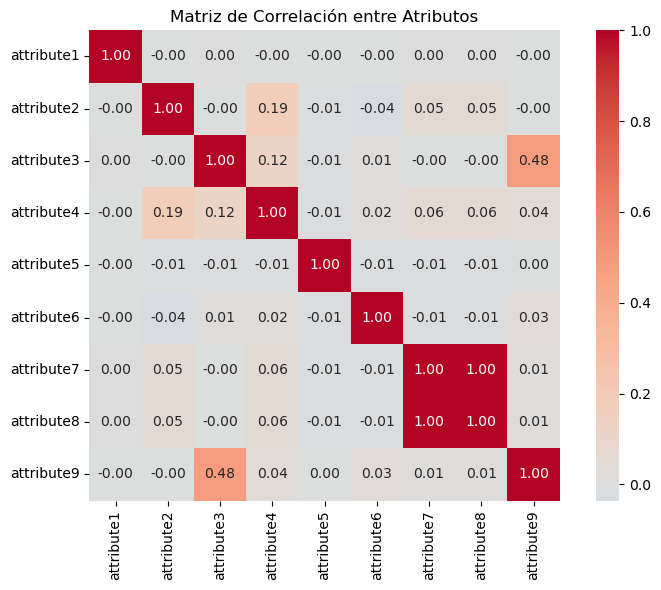

In [7]:
# Calculamos la matriz de correlación
correlation_matrix = X_train.corr()

# Creamos una figura con un tamaño específico
plt.figure(figsize=(8, 6))

# Generamos el mapa de calor usando seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Muestra los valores numéricos
            cmap='coolwarm',  # Esquema de colores
            center=0,  # Centro del mapa de calor
            fmt='.2f',  # Formato de los números (2 decimales)
            square=True)  # Hace que las celdas sean cuadradas

plt.title('Matriz de Correlación entre Atributos')
plt.tight_layout()
plt.show()


Podemos ver que la variable 7 y 8 tienen una correlacion perfecta por lo que no es necesario contar con ambas para el analisis. Veamos si son iguales o no. Si son exactamente iguales en todos los casos, vamos a dropearlas en todos los datasets

In [8]:
# Comparamos si attribute7 y attribute8 son iguales
print("¿Son iguales attribute7 y attribute8?")
print((X_train['attribute7'] == X_train['attribute8']).all())

# Eliminamos attribute8 de los conjuntos de datos ya que es idéntico a attribute7
X_train = X_train.drop('attribute8', axis=1)
X_test = X_test.drop('attribute8', axis=1) 
X_val = X_val.drop('attribute8', axis=1)



¿Son iguales attribute7 y attribute8?
True


In [9]:
# Verificamos valores nulos en X_train
print("Valores nulos en X_train:")
print(X_train.isnull().sum())

print("\nValores nulos en X_val:")
print(X_val.isnull().sum())

Valores nulos en X_train:
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute9    0
dtype: int64

Valores nulos en X_val:
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute9    0
dtype: int64


### Variable objetivo

In [10]:
y_train.value_counts(normalize=True)

failure
0    0.999116
1    0.000884
Name: proportion, dtype: float64

Podemos apreciar que la variable objetivo esta muy desbalanceada.

### Entrenamiento del modelo

Para datos tabulares con una cantidad de datos entre baja y media (nuestro caso con 100k filas) los modelos que mejor performan son los basados en arboles. Dicho esto utilizare LightGBM como modelo base, por su architectura de arboles, sus mejoras varias y velocidad. 


Falso Negativo (no detectar una falla y que falle) = costo 1.0

Falso Positivo (mantenimiento innecesario) = costo 0.5

True Positive (mantenimiento necesario) = costo 0.5

True negative (detectar que no necesita mantenimiento correctamente) = costo 0 

In [11]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import numpy as np
from itertools import product


In [220]:
def custom_cost_metric(y_pred, dtrain, threshold=0.5):
    """
    y_pred: probabilidades predichas por el modelo
    dtrain: Dataset de LightGBM que contiene los valores reales
    threshold: umbral para convertir probabilidades a predicciones binarias (default 0.5)
    """
    # Obtenemos los valores reales del dataset
    y_true = dtrain.get_label()
    
    # Convertimos probabilidades a predicciones binarias usando el threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculamos la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Calculamos el costo total
    cost_fn = fn * 1.0  # Costo de no detectar una falla
    cost_fp = fp * 0.5  # Costo de mantenimiento innecesario
    cost_tp = tp * 0.5
    total_cost = cost_fn + cost_fp + cost_tp
    
    # LightGBM espera (eval_name, eval_result, is_higher_better)
    return 'custom_cost', total_cost, False


def calcular_metricas_y_costos(y_true, y_pred):
    # Calculamos la matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print("Matriz de confusión en el conjunto de prueba:")
    print(f"Verdaderos Negativos (TN): {tn}")
    print(f"Falsos Positivos (FP): {fp}") 
    print(f"Falsos Negativos (FN): {fn}")
    print(f"Verdaderos Positivos (TP): {tp}")

    # Calculamos el costo total
    cost_fn = fn * 1.0  # Costo de no detectar una falla
    cost_fp = fp * 0.5  # Costo de mantenimiento innecesario
    cost_tp = tp * 0.5
    total_cost = cost_fn + cost_fp + cost_tp

    print(f"\nCostos en el conjunto de prueba:")
    print(f"Costo por Falsos Negativos: {cost_fn}")
    print(f"Costo por Falsos Positivos: {cost_fp}")
    print(f"Costo por True Positives: {cost_tp}")
    print(f"Costo Total: {total_cost}")
    
    return tn, fp, fn, tp, cost_fn, cost_fp, total_cost


In [217]:
# Creamos los datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [241]:
# Parámetros del modelo actualizados
params = {
    'objective': 'binary',
    'metric': ['average_precision', "auc", "custom_cost"], #en este caso aunque estemos especificando nuestra metrica, estamos optimizando por average_precision
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    "is_unbalanced": True
}


# Entrenamos el modelo usando solo nuestra métrica personalizada
initial_model = lgb.train(
    params,
    train_data,  # Dataset de entrenamiento
    num_boost_round=1000,
    valid_sets=[train_data, val_data],  # Lista de datasets de validación
    valid_names=['training', 'validation'],  # Nombres de los datasets
    feval=custom_cost_metric,  # Nuestra métrica personalizada
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), #El early stopping ayuda a evitar overfitting
        lgb.log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 50 rounds
[10]	training's average_precision: 0.274556	training's auc: 0.930954	training's custom_cost: 103	validation's average_precision: 0.0587722	validation's auc: 0.454027	validation's custom_cost: 37.5
[20]	training's average_precision: 0.394889	training's auc: 0.98531	training's custom_cost: 75.5	validation's average_precision: 0.0589589	validation's auc: 0.568949	validation's custom_cost: 34
[30]	training's average_precision: 0.574111	training's auc: 0.996801	training's custom_cost: 69.5	validation's average_precision: 0.059095	validation's auc: 0.611763	validation's custom_cost: 33.5
[40]	training's average_precision: 0.751464	training's auc: 0.999499	training's custom_cost: 63	validation's average_precision: 0.0599569	validation's auc: 0.646067	validation's custom_cost: 34.5
[50]	training's average_precision: 0.864026	training's auc: 0.999856	training's custom_cost: 59.5	validation's average_precision: 0.0595342	validation's a

In [242]:
# Hacemos predicciones en el conjunto de prueba
y_pred_test = initial_model.predict(X_test)
y_pred_test_binary = (y_pred_test >= 0.5).astype(int)

# Calculamos las métricas y costos usando la función
tn, fp, fn, tp, cost_fn, cost_fp, total_cost = calcular_metricas_y_costos(y_test, y_pred_test_binary)


Matriz de confusión en el conjunto de prueba:
Verdaderos Negativos (TN): 18545
Falsos Positivos (FP): 119
Falsos Negativos (FN): 9
Verdaderos Positivos (TP): 2

Costos en el conjunto de prueba:
Costo por Falsos Negativos: 9.0
Costo por Falsos Positivos: 59.5
Costo por True Positives: 1.0
Costo Total: 69.5


El costo total en el dataset de test, con este modelo, es de 65. Veamos si podemos mejorarlo optimizando hiperparametros

In [ ]:

# Definimos el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50,100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'max_depth': [5, 10,-1],
     'subsample': [0.8, 0.9, 1.0]
}

# Generamos todas las combinaciones de parámetros
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Lista para almacenar resultados
results = []


# Parámetros base que no cambiarán
base_params = {
    'objective': 'binary',
    'metric': ['average_precision', "auc","custom_cost"],
    'verbose': -1,
    'boosting_type': 'gbdt',
    "is_unbalanced":True,
}

# Probamos cada combinación de parámetros
for params in param_combinations:
    # Combinamos los parámetros base con los específicos de esta iteración
    current_params = {**base_params, **params}
    
    # Entrenamos el modelo
    model = lgb.train(
        params=current_params,
        train_set=train_data,
        num_boost_round=1000,
        valid_sets=[val_data],  # Solo el conjunto de validación
        valid_names=['valid'],  # Solo un nombre
        feval=custom_cost_metric,
        callbacks=[
            lgb.early_stopping(stopping_rounds=40, first_metric_only=True),
            lgb.log_evaluation(period=10)  # Mostramos logs cada 100 iteraciones
        ]
    )
    
    # Guardamos los resultados
    results.append({
        'params': params,
        'best_iteration': model.best_iteration,
        'best_score': model.best_score['valid']['custom_cost'],
        'model': model
    })


In [231]:

# Encontramos la mejor combinación
best_result = min(results, key=lambda x: x['best_score'])

print("Mejores parámetros encontrados:")
print(best_result['params'])
print(f"Mejor score: {best_result['best_score']}")
print(f"Mejor iteración: {best_result['best_iteration']}")

# Guardamos el mejor modelo
best_model = best_result['model']

Mejores parámetros encontrados:
{'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 0.7, 'max_depth': 5, 'subsample': 0.8}
Mejor score: 18.0
Mejor iteración: 2


In [232]:
# Hacemos predicciones en el conjunto de prueba
y_pred_test = best_model.predict(X_test)
y_pred_test_binary = (y_pred_test >= 0.5).astype(int)

# Calculamos las métricas y costos
tn, fp, fn, tp, cost_fn, cost_fp, total_cost = calcular_metricas_y_costos(y_test, y_pred_test_binary)


Matriz de confusión en el conjunto de prueba:
Verdaderos Negativos (TN): 18664
Falsos Positivos (FP): 0
Falsos Negativos (FN): 11
Verdaderos Positivos (TP): 0

Costos en el conjunto de prueba:
Costo por Falsos Negativos: 11.0
Costo por Falsos Positivos: 0.0
Costo por True Positives: 0.0
Costo Total: 11.0


Podemos ver que el costo disminuyó considerablemente al optimizar los hiperparametros, pero el modelo pareceria no estar prediciendo nunca que la maquina fallará, lo cual debería levantarnos una alarma de problemas en el entrenamiento, esto podría ser causado por un overfitting contra el train set. 

Veamos como se comportan la logloss de train y de validacion para este modelo en particular.


In [234]:

# Parámetros del modelo actualizados
best_params = {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 0.9,  
          
          "is_unbalanced":True,
          'max_depth': 5, 'subsample': 0.8, 'objective': 'binary',
    'metric': "average_precision",
    'verbose': -1,
    'boosting_type': 'gbdt'}


# Entrenamos el modelo usando solo nuestra métrica personalizada
model = lgb.train(
    best_params,
    train_data,  # Dataset de entrenamiento
    num_boost_round=1000,
    valid_sets=[train_data, val_data],  # Lista de datasets de validación
    valid_names=['training', 'validation'],  # Nombres de los datasets
    feval=custom_cost_metric,  # Nuestra métrica personalizada
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 200 rounds
[10]	training's average_precision: 0.312118	training's custom_cost: 77	validation's average_precision: 0.0206448	validation's custom_cost: 18
[20]	training's average_precision: 0.394038	training's custom_cost: 77	validation's average_precision: 0.0202176	validation's custom_cost: 18
[30]	training's average_precision: 0.443553	training's custom_cost: 77	validation's average_precision: 0.0204064	validation's custom_cost: 18
[40]	training's average_precision: 0.478011	training's custom_cost: 77	validation's average_precision: 0.0206525	validation's custom_cost: 18
[50]	training's average_precision: 0.511083	training's custom_cost: 77	validation's average_precision: 0.0163952	validation's custom_cost: 18
[60]	training's average_precision: 0.528172	training's custom_cost: 77	validation's average_precision: 0.016262	validation's custom_cost: 18
[70]	training's average_precision: 0.550709	training's custom_cost: 77	validation's ave

Quitando el early stopping de 50, podemos ver que la average_precision de entrenamiento baja mientras que la de validacion sube, junto con el costo. Queda claro que estamos overfitteando por lo que el early stopping es una buena practica en este caso.

Utilizamos average precision porque corresponde al area bajo la curva de Precision-Recall PR-AUC la cual es recomendada para casos desbalanceados

Agregando granularidad al loggeo queda claro que el modelo converge en validacion en el epoch 45, luego de esto overfitteando.

In [235]:
pd.Series(y_pred_test_binary).value_counts()


0    18675
Name: count, dtype: int64

Como podemos ver el modelo sigue sin predecir que la maquina fallará, si lo pensamos mejor, nuestro threshold esta puesto en 0.5

Tenemos que hacer un trabajo de calibración del modelo, la calibración de modelos es especialmente importante cuando trabajamos con predicciones de probabilidad. 

La calibración se refiere a qué tan bien las probabilidades predichas por el modelo corresponden a las frecuencias observadas reales. Por ejemplo, cuando tu modelo predice una probabilidad de 0.8, idealmente el 80% de esos casos deberían ser positivos en la realidad.

In [236]:
# En nuestro caso el ratio de falla es:
ratio_falla = len(y_train[y_train==1]) / len(y_train)
print(f"El ratio de fallas es: {ratio_falla:.4}")


El ratio de fallas es: 0.0008836


In [239]:
# Calculamos las probabilidades predichas para el conjunto de prueba
y_pred_test_proba = model.predict(X_test)

# Calculamos el promedio de las probabilidades predichas
promedio_fallas = np.mean(y_pred_test_proba)
print(f"El promedio de probabilidades de falla predichas es: {promedio_fallas:.4f}")


El promedio de probabilidades de falla predichas es: 0.0010


Lo cual no está muy alejado de lo que nos interesaría!

### Ejemplo curva de calibracion de nuestro modelo inicial

In [237]:
from sklearn.calibration import CalibrationDisplay

def graficar_curva_calibracion(modelo, X_test, y_test, n_bins=10, nombre_modelo="LightGBM", 
                              tamano_figura=(10,6)):
    # Obtenemos las predicciones
    y_pred_proba = modelo.predict(X_test)
    
    # Configuramos el tamaño de la figura
    plt.figure(figsize=tamano_figura)
    
    # Creamos y mostramos la curva de calibración
    CalibrationDisplay.from_predictions(
        y_test,
        y_pred_proba,
        n_bins=n_bins,
        name=nombre_modelo
    )
    
    plt.title("Curva de Calibración del Modelo")
    plt.xlabel("Probabilidad Media Predicha")
    plt.ylabel("Fracción de Positivos")
    plt.grid(True)
    plt.show()

<Figure size 1000x600 with 0 Axes>

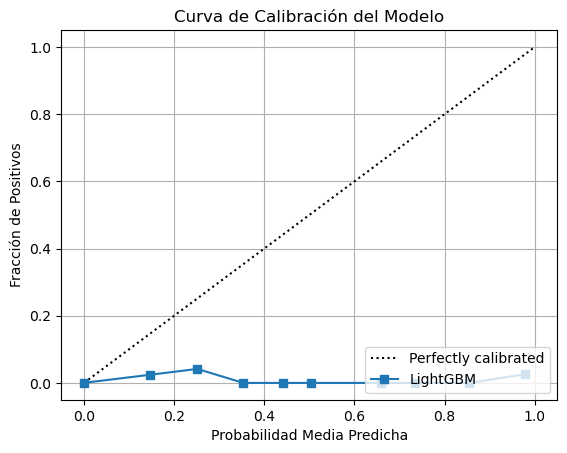

In [243]:
# Llamamos a la función con los parámetros actuales
graficar_curva_calibracion(initial_model, X_test, y_test)


Esta curva de calibración muestra un problema serio de calibración en el modelo.

Está muy por debajo de la línea perfecta y muestra una fracción de positivos muy baja para las probabilidades predichas, significa que el modelo no está bien calibrado. Es posible que esté asignando probabilidades muy bajas a muchos ejemplos que en realidad son positivos, lo que puede ser un indicativo de problema en el aprendizaje, como el desbalanceo de clases.

Probemos con un metodo de calibración sencillo como es utilizar sklearn

CalibratedClassifierCV es un calibrador de probabilidades que ajusta las predicciones de un clasificador
para que sean más precisas como probabilidades reales. Utiliza validación cruzada y puede usar diferentes
métodos de calibración como 'sigmoid' (Platt) o 'isotonic'. Es especialmente útil cuando:

- El clasificador base no produce buenas probabilidades (como SVM o Random Forests)
- Hay desbalanceo de clases  
- Se necesitan probabilidades bien calibradas para toma de decisiones

Scikit-learn implementa dos métodos de calibración:

1. Calibración de Platt (método 'sigmoid'): Ajusta una regresión logística a las predicciones del modelo 
   base para transformarlas en probabilidades calibradas.

2. Calibración isotónica (método 'isotonic'): Aprende una función monótona no paramétrica para mapear las 
   predicciones a probabilidades calibradas. Es más flexible que la calibración de Platt pero requiere 
   más datos para evitar el sobreajuste.

In [260]:
from sklearn.calibration import CalibratedClassifierCV

# Ajusta el modelo original
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Calibración
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_val, y_val)

# Ahora puedes predecir y evaluar la calibración
probabilities = calibrated_model.predict_proba(X_val)[:, 1]

/opt/anaconda3/envs/meli_challenge/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

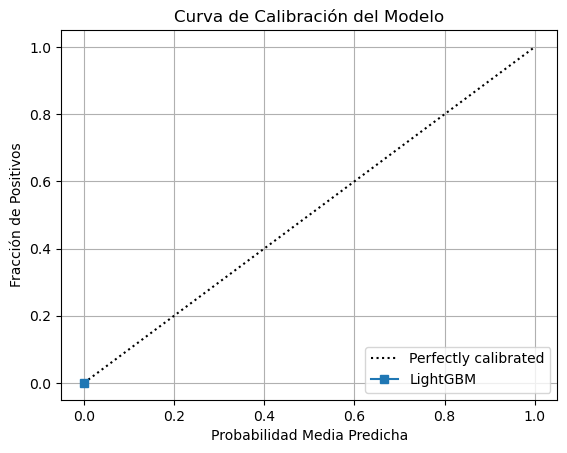

In [261]:
# Llamamos a la función con los parámetros actuales
graficar_curva_calibracion(calibrated_model, X_test, y_test,n_bins=100)


Ahora si, la curva de calibración cae sobre la perfecta, aunque solo se vea como un punto. Esto se debe al alto desbalanceo del dataset!

### Calcular el umbral para determinar el costo minimo

Ahora debemos calcular el umbral óptimo, utilizando nuestra casuistica de negocio, para determinar en qué threshold de probabilidad el modelo debería predecir falla o no falla. Esto no es estrictamente requerido en el challenge pero vamos a hacerlo de cualquier manera. El umbral lo seleccionamos utilizando el dataset de validation y luego lo aplicamos en el de test para ver nuestro costo total!

Umbral óptimo: 0.14
Costo total mínimo: 18.0


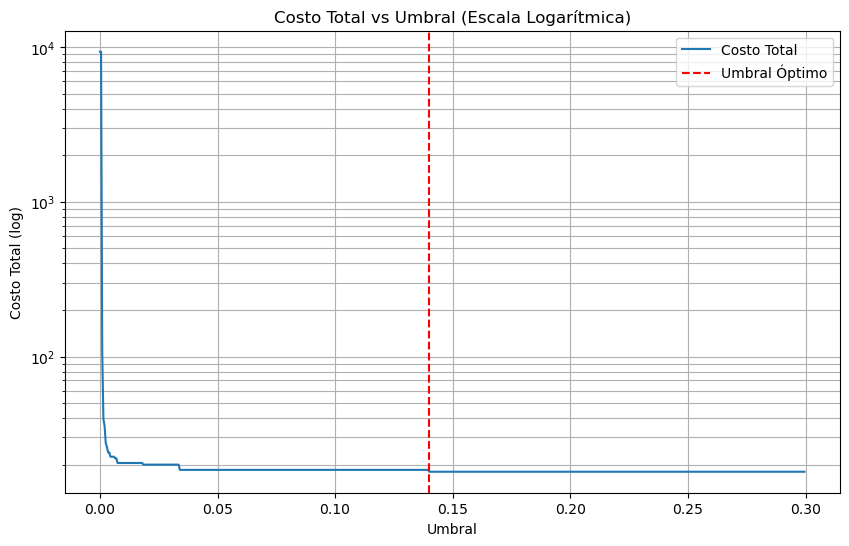

In [262]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def calcular_umbral_optimo(y_val, probabilities, cost_fn=1, cost_fp=0.5, cost_tp=0.5, max_threshold=0.3, step=0.0005):
    """
    Calcula el umbral óptimo que minimiza el costo total.
    
    Args:
        y_val: Valores reales
        probabilities: Probabilidades predichas
        cost_fn: Costo de falsos negativos (default 1)
        cost_fp: Costo de falsos positivos (default 0.5)
        cost_tp: Costo de verdaderos positivos (default 0.5)
        max_threshold: Valor máximo del umbral a probar (default 0.3)
        step: Paso entre umbrales (default 0.0005)
    
    Returns:
        optimal_threshold: Umbral óptimo
        optimal_cost: Costo mínimo encontrado
        thresholds: Lista de umbrales probados
        costs: Lista de costos para cada umbral
    """
    # Valores únicos de probabilidad que pueden usarse como umbrales
    thresholds = np.arange(0.0, max_threshold, step)
    
    # Inicializamos el costo total
    costs = []
    
    for threshold in thresholds:
        # Realizamos las predicciones basadas en el umbral
        predictions = (probabilities >= threshold).astype(int)
        
        # Calculamos la matriz de confusión
        tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
        
        # Calcular el costo total
        total_cost = (fn * cost_fn) + (fp * cost_fp) + (tp * cost_tp)
        costs.append(total_cost)

    # Encontrar el umbral que minimiza el costo
    optimal_threshold_index = np.argmin(costs)
    optimal_threshold = thresholds[optimal_threshold_index]
    optimal_cost = costs[optimal_threshold_index]
    
    return optimal_threshold, optimal_cost, thresholds, costs

# Calculamos el umbral óptimo
optimal_threshold, optimal_cost, thresholds, costs = calcular_umbral_optimo(y_val, probabilities)

print(f"Umbral óptimo: {optimal_threshold}")
print(f"Costo total mínimo: {optimal_cost}")

# Graficar el costo total en función del umbral
plt.figure(figsize=(10, 6))
plt.semilogy(thresholds, costs, label='Costo Total')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Umbral Óptimo')
plt.title('Costo Total vs Umbral (Escala Logarítmica)')
plt.xlabel('Umbral')
plt.ylabel('Costo Total (log)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

In [263]:
# Hacemos predicciones en el conjunto de prueba
y_pred_test = model.predict(X_test)
y_pred_test_binary = (y_pred_test >= optimal_threshold).astype(int)

# Calculamos las métricas y costos
tn, fp, fn, tp, cost_fn, cost_fp, total_cost = calcular_metricas_y_costos(y_test, y_pred_test_binary)


Matriz de confusión en el conjunto de prueba:
Verdaderos Negativos (TN): 18659
Falsos Positivos (FP): 5
Falsos Negativos (FN): 10
Verdaderos Positivos (TP): 1

Costos en el conjunto de prueba:
Costo por Falsos Negativos: 10.0
Costo por Falsos Positivos: 2.5
Costo por True Positives: 0.5
Costo Total: 13.0


In [249]:
pd.Series(y_pred_test_binary).value_counts()

0    18669
1        6
Name: count, dtype: int64

Ahora el modelo dejó de solo predecir no falla :) y nuestro costo total sigue en valores controlados para el set de test

### SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE es una técnica de sobremuestreo que crea instancias sintéticas de la clase minoritaria. En lugar de hacer copias exactas, SMOTE:
1. Toma un punto de la clase minoritaria
2. Encuentra sus k vecinos más cercanos
3. Crea puntos sintéticos entre el punto original y sus vecinos

Esto ayuda a balancear el dataset sin causar overfitting por duplicación exacta de datos. Presentemos un ejemplo y analicemos si logramos que mejore la predicción en la detección de fallas sin generar demasiados falsos negativos. Para esto vamos a tener que volver a calibrar el modelo y seleccionar el threshold optimo. 

In [276]:
# 1. Parte de Sampling con SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# Veamos la distribución original
print("Distribución original de clases:")
print(Counter(y_train))

# Aplicamos SMOTE solo a los datos de entrenamiento
smote = SMOTE(
    sampling_strategy=0.5,  # La clase minoritaria será el 50% de la mayoritaria
    random_state=42
)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Veamos la nueva distribución
print("\nDistribución después de SMOTE:")
print(Counter(y_train_resampled))

Distribución original de clases:
Counter({0: 87068, 1: 77})

Distribución después de SMOTE:
Counter({0: 87068, 1: 43534})


In [277]:

best_params={'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 0.9,  
          "is_unbalanced":True,
          'max_depth': 5, 'subsample': 0.8, 'objective': 'binary',
    'metric': "auc",
    'verbose': -1,
    'boosting_type': 'gbdt'}

# Ajusta el modelo original
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_resampled, y_train_resampled)

# Calibración
smote_calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
smote_calibrated_model.fit(X_val, y_val)

/opt/anaconda3/envs/meli_challenge/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(feature_fraction=0.9,
                                                is_unbalanced=True,
                                                learning_rate=0.01, max_depth=5,
                                                metric='auc',
                                                objective='binary',
                                                subsample=0.8, verbose=-1))

Umbral óptimo: 0.051500000000000004
Costo total mínimo: 17.5


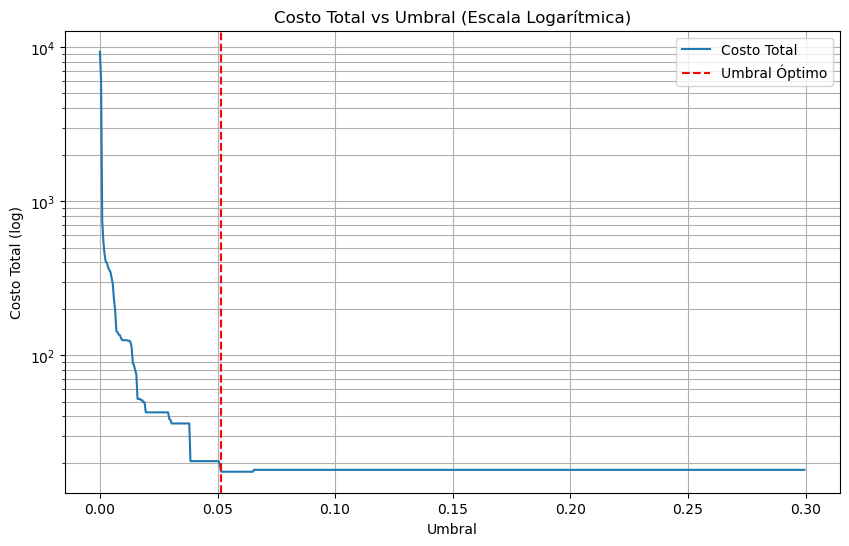

In [278]:
# Calculamos el umbral óptimo para el modelo calibrado con SMOTE
y_pred_val_proba = smote_calibrated_model.predict_proba(X_val)[:, 1]
optimal_threshold, optimal_cost, thresholds, costs = calcular_umbral_optimo(y_val, y_pred_val_proba)


print(f"Umbral óptimo: {optimal_threshold}")
print(f"Costo total mínimo: {optimal_cost}")

# Graficar el costo total en función del umbral
plt.figure(figsize=(10, 6))
plt.semilogy(thresholds, costs, label='Costo Total')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Umbral Óptimo')
plt.title('Costo Total vs Umbral (Escala Logarítmica)')
plt.xlabel('Umbral')
plt.ylabel('Costo Total (log)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


In [279]:
# Hacemos predicciones en el conjunto de prueba
y_pred_test = smote_calibrated_model.predict(X_test)
y_pred_test_binary = (y_pred_test >= optimal_threshold).astype(int)

# Calculamos las métricas y costos
tn, fp, fn, tp, cost_fn, cost_fp, total_cost = calcular_metricas_y_costos(y_test, y_pred_test_binary)

Matriz de confusión en el conjunto de prueba:
Verdaderos Negativos (TN): 18664
Falsos Positivos (FP): 0
Falsos Negativos (FN): 11
Verdaderos Positivos (TP): 0

Costos en el conjunto de prueba:
Costo por Falsos Negativos: 11.0
Costo por Falsos Positivos: 0.0
Costo por True Positives: 0.0
Costo Total: 11.0


In [280]:
pd.Series(y_pred_test_binary).value_counts()

0    18675
Name: count, dtype: int64

Análisis de predicciones en fallas conocidas:
Total de fallas en train: 77
Fallas correctamente identificadas: 20
Fallas no identificadas: 57
Porcentaje de detección: 25.97%


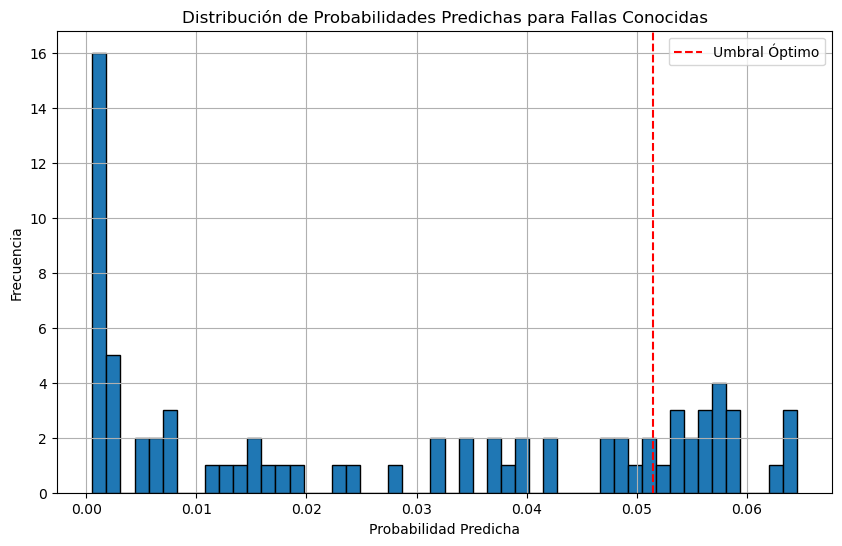

In [283]:
# Seleccionamos las filas con fallas del conjunto de entrenamiento
fallas_train = X_train[y_train == 1]

# Hacemos predicciones sobre estas fallas
pred_fallas = smote_calibrated_model.predict_proba(fallas_train)[:, 1]
pred_fallas_binary = (pred_fallas >= optimal_threshold).astype(int)

print("Análisis de predicciones en fallas conocidas:")
print(f"Total de fallas en train: {len(fallas_train)}")
print(f"Fallas correctamente identificadas: {sum(pred_fallas_binary == 1)}")
print(f"Fallas no identificadas: {sum(pred_fallas_binary == 0)}")
print(f"Porcentaje de detección: {(sum(pred_fallas_binary == 1)/len(fallas_train))*100:.2f}%")

# Mostramos la distribución de las probabilidades predichas
plt.figure(figsize=(10, 6))
plt.hist(pred_fallas, bins=50, edgecolor='black')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Umbral Óptimo')
plt.title('Distribución de Probabilidades Predichas para Fallas Conocidas')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()


El modelo no esta prediciendo fallas en el dataset de test, pero si detecta parcialmente las fallas en el dataset de train, lo que nos da una buena señal de que el modelo no ha aprendido simplemente a *predecir cero*.

Existen mas tecnicas de sampling que se pueden explorar y otros modelos a considerar para su experimentación, pero considero que estos resultados ya son aceptables. 